In [1]:
import pandas as pd
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from torch import nn, optim
import time
from tempfile import TemporaryDirectory
import os

device = torch.device('cuda:0')

In [2]:
rows = pd.read_csv('content/outFrames/content.csv')
rows['class'] = rows['class'].fillna('None')

In [3]:
frames = { 'Train': [], 'Test': [] }
class_idxs =  { 'UD': 0, 'WF': 1, 'None': 2 } 
class_names = [ 'UD', 'WF', 'None' ]
main_ndarray = np.load('content/frame_array.npy')
main_ndarray = main_ndarray.astype('float32')

# BGR->RGB
main_ndarray = np.stack([
    main_ndarray[:, :, :, 2],
    main_ndarray[:, :, :, 1],
    main_ndarray[:, :, :, 0],
], axis=-1)
# (H,W,C) -> (C,W,H)
main_ndarray = main_ndarray.transpose((0, 3, 1, 2))
# Normalize
main_ndarray = (main_ndarray - 128.0) / 128.0 

grouped = rows.groupby(['video_name', 'interval', 'class', 'type'], as_index=False)
count = 0
for grp, values in grouped:
    if len(values) < 16:
        continue

    # TODO: Can get more sample if values is larger than 16 frame
    idxs = []
    for idx, row in values.iterrows():
        idxs.append(idx)
        if len(idxs) == 16:
            frame_ndarray = main_ndarray[idxs,]
            frames[grp[3]].append((frame_ndarray, class_idxs[grp[2]]))
            idxs = []

In [4]:
dataloaders = {
    'Train': torch.utils.data.DataLoader(frames['Train'], batch_size=4, shuffle=True, num_workers=4),
    'Test': torch.utils.data.DataLoader(frames['Test'], batch_size=4, shuffle=True, num_workers=4),
}

dataset_sizes = {
    'Train': len(frames['Train']),
    'Test': len(frames['Test']), 
}

print(f'Size of training set {dataset_sizes["Train"]}')
print(f'Size of testing set {dataset_sizes["Test"]}')

Size of training set 196
Size of testing set 56


In [18]:
label_count = {}
for _, k in frames["Train"]:
    if class_names[k] not in label_count:
        label_count[class_names[k]] = 0
    label_count[class_names[k]] += 1

label_count

{'None': 70, 'UD': 64, 'WF': 62}

In [5]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


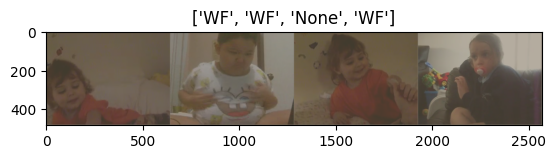

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

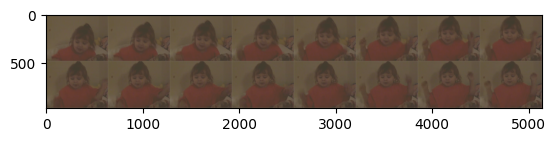

In [7]:
# Get a frame
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[0,:]

# Make a grid from frame
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [8]:
def train_model(model, criterion, optimizer, scheduler, transform=None, num_epochs=25):
    since = time.time()
    losses = {'Train': [], 'Test': []}
    accuracies = {'Train': [], 'Test': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = './best_model_params.pt'

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['Train', 'Test']:
                if phase == 'Train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    if transform != None:
                        inputs = transform(inputs).to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                losses[phase].append(float(epoch_loss))
                accuracies[phase].append(float(epoch_acc))

                # deep copy the model
                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            # Stop early on two consecutive higher test loss
            #if len(losses['Test']) > 2 and losses['Test'][-1] > losses['Test'][-2] and losses['Test'][-2] > losses['Test'][-3]:
            #    break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    _, axes = plt.subplots(2, 1)
    axes[0].plot(losses['Train'], label='Train loss')
    axes[0].plot(losses['Test'], label='Test loss')
    axes[0].legend()
    
    axes[1].plot(accuracies['Train'], label='Train accuracy')
    axes[1].plot(accuracies['Test'], label='Test accuracy')
    axes[1].legend()
    
    return model

In [12]:
class VideoModel(nn.Module):

    def __init__(self):
        super(VideoModel, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv3d(3, 4, 3),
            nn.BatchNorm3d(4),
            nn.LeakyReLU(),
            nn.MaxPool3d((1, 2, 2)),
        )
        self.block2 = nn.Sequential(
            nn.Conv3d(4, 16, 3),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(),
            nn.MaxPool3d((1, 2, 2)),
        )
        self.block3 = nn.Sequential(
            nn.Conv3d(16, 64, 3),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(),
            nn.MaxPool3d((1, 4, 4)),
        )
        self.block4 = nn.Sequential(
            nn.Conv3d(64, 256, 3),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(),
            nn.MaxPool3d((1, 4, 4)),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveMaxPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 3),
        )

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        #print(x.shape)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.classifier(x)

        return x



In [13]:
import torchvision.transforms.v2 as transforms

model_ft = VideoModel()
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.0000000)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_ft

VideoModel(
  (block1): Sequential(
    (0): Conv3d(3, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv3d(16, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool3d(kernel_size=(1, 4, 4), stride=(1, 4, 4), padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
  

Epoch 0/49
----------
Train Loss: 1.1763 Acc: 0.3520
Test Loss: 1.1511 Acc: 0.3214
Epoch 1/49
----------
Train Loss: 1.0532 Acc: 0.4439
Test Loss: 1.1908 Acc: 0.3214
Epoch 2/49
----------
Train Loss: 1.0874 Acc: 0.3980
Test Loss: 1.0753 Acc: 0.4821
Epoch 3/49
----------
Train Loss: 1.0090 Acc: 0.4898
Test Loss: 1.1327 Acc: 0.3214
Epoch 4/49
----------
Train Loss: 1.0297 Acc: 0.4694
Test Loss: 1.0795 Acc: 0.2321
Epoch 5/49
----------
Train Loss: 0.9073 Acc: 0.5306
Test Loss: 0.9636 Acc: 0.5357
Epoch 6/49
----------
Train Loss: 0.9098 Acc: 0.5663
Test Loss: 1.3376 Acc: 0.3571
Epoch 7/49
----------
Train Loss: 0.9151 Acc: 0.5408
Test Loss: 0.9889 Acc: 0.4821
Epoch 8/49
----------
Train Loss: 0.8560 Acc: 0.5663
Test Loss: 0.9817 Acc: 0.5179
Epoch 9/49
----------
Train Loss: 0.8108 Acc: 0.5714
Test Loss: 1.0665 Acc: 0.4464
Epoch 10/49
----------
Train Loss: 0.8194 Acc: 0.6224
Test Loss: 1.0741 Acc: 0.4821
Epoch 11/49
----------
Train Loss: 0.7961 Acc: 0.6429
Test Loss: 1.1046 Acc: 0.4286
Ep

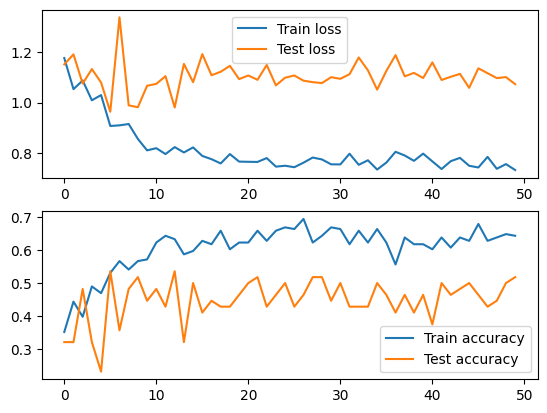

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, transform=model_transform,
                       num_epochs=50)

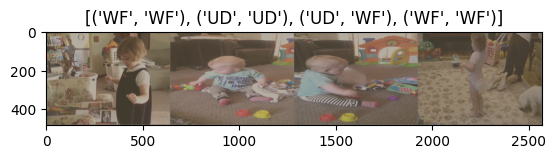

In [15]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Test']))

inferred_class = model_ft(inputs.to(device))

predicted_class = list(torch.argmax(inferred_class, dim=-1))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[(class_names[classes[x]], class_names[predicted_class[x]]) for x in range(len(classes))])

In [16]:
from sklearn.metrics import confusion_matrix

true_label = []
predicted_label = []
for input, label in dataloaders['Train']:
    true_label = true_label + label.tolist()
    pred = model_ft(model_transform(input).to(device))
    pred = pred.argmax(-1)
    predicted_label = predicted_label + pred.tolist()


In [17]:
confusion_matrix(true_label, predicted_label)

array([[55,  9,  0],
       [ 4, 58,  0],
       [24, 44,  2]])